# Validacion E1-E11: Event Detection Complete

**Fecha**: 2025-10-29  
**Objetivo**: Validar deteccion completa de eventos E1-E11 con 3,459,349 eventos totales

---

## Scope

Validar:
1. Conteo de eventos por tipo (E1-E11)
2. Distribucion temporal de eventos
3. Top tickers por evento
4. Validacion flag `intraday_confirmed=False` en E3/E9
5. Schema consistency across all event types
6. Overlap analysis: cuantos dias tienen multiples eventos

---

In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print('Polars version:', pl.__version__)
print('Matplotlib version:', plt.matplotlib.__version__)

Polars version: 1.34.0
Matplotlib version: 3.10.7


## 1. Load All Events E1-E11

In [2]:
# Necesitamos subir 4 niveles para llegar al root
project_root = Path.cwd().parent.parent.parent.parent
events_dir = project_root / 'processed' / 'events'

print(f'Working directory: {Path.cwd()}')
print(f'Project root: {project_root}')
print(f'Events dir: {events_dir}')
print(f'Events dir exists: {events_dir.exists()}')
print()

# Expected counts from detection
expected_counts = {
    'E1': 164_941,
    'E2': 73_170,
    'E3': 144_062,
    'E4': 197_716,
    'E5': 412_902,
    'E6': 1_543_990,
    'E7': 16_919,
    'E8': 19_924,
    'E9': 24_074,
    'E10': 814_068,
    'E11': 47_583
}

# Load all events
dfs = {}
for event_type in expected_counts.keys():
    event_file = events_dir / f'events_{event_type.lower()}.parquet'
    if event_file.exists():
        df = pl.read_parquet(event_file)
        dfs[event_type] = df
        print(f'{event_type}: {len(df):,} events (expected: {expected_counts[event_type]:,})')
    else:
        print(f'{event_type}: FILE NOT FOUND ({event_file})')

print()
print(f'Total events loaded: {sum(len(df) for df in dfs.values()):,}')
print(f'Expected total: {sum(expected_counts.values()):,}')

Working directory: d:\04_TRADING_SMALLCAPS\01_DayBook\fase_01\E_Event Detectors E1, E4, E7, E8\notebooks
Project root: d:\04_TRADING_SMALLCAPS
Events dir: d:\04_TRADING_SMALLCAPS\processed\events
Events dir exists: True

E1: 164,941 events (expected: 164,941)
E2: 73,170 events (expected: 73,170)
E3: 144,062 events (expected: 144,062)
E4: 197,716 events (expected: 197,716)
E5: 412,902 events (expected: 412,902)
E6: 1,543,990 events (expected: 1,543,990)
E7: 16,919 events (expected: 16,919)
E8: 19,924 events (expected: 19,924)
E9: 24,074 events (expected: 24,074)
E10: 814,068 events (expected: 814,068)
E11: 47,583 events (expected: 47,583)

Total events loaded: 3,459,349
Expected total: 3,459,349


## 2. Validate Schema: E3 and E9 Have `intraday_confirmed` Flag

In [3]:
print('=== SCHEMA VALIDATION ===')
print()

for event_type, df in dfs.items():
    print(f'{event_type} Schema:')
    for col, dtype in zip(df.columns, df.dtypes):
        print(f'  {col}: {dtype}')
    
    # Check for intraday_confirmed flag in E3/E9
    if event_type in ['E3', 'E9']:
        if 'intraday_confirmed' in df.columns:
            flag_value = df['intraday_confirmed'][0]
            print(f'  ✅ intraday_confirmed flag present: {flag_value}')
        else:
            print(f'  ❌ intraday_confirmed flag MISSING')
    
    print()

=== SCHEMA VALIDATION ===

E1 Schema:
  ticker: String
  date: Date
  event_type: String
  rvol: Float64
  v: Float64
  avg_vol: Float64
  c: Float64

E2 Schema:
  ticker: String
  date: Date
  event_type: String
  gap_pct: Float64
  prev_close: Float64
  o: Float64
  h: Float64
  l: Float64
  c: Float64
  v: Float64

E3 Schema:
  ticker: String
  date: Date
  event_type: String
  spike_pct: Float64
  intraday_confirmed: Boolean
  o: Float64
  h: Float64
  l: Float64
  c: Float64
  v: Float64
  ✅ intraday_confirmed flag present: False

E4 Schema:
  ticker: String
  date_start: Date
  date_end: Date
  event_type: String
  pct_change: Float64
  days: Int32
  start_price: Float64
  end_price: Float64

E5 Schema:
  ticker: String
  date: Date
  event_type: String
  c: Float64
  prev_high: Float64
  o: Float64
  h: Float64
  l: Float64
  v: Float64

E6 Schema:
  ticker: String
  date: Date
  event_type: String
  green_days_count: Int32
  o: Float64
  h: Float64
  l: Float64
  c: Float64
  v

## 3. Event Count Summary Table

In [6]:
summary_data = []

event_descriptions = {
    'E1': 'Volume Explosion (RVOL > 5x)',
    'E2': 'Gap Up (+10%)',
    'E3': 'Price Spike Intraday (+20%) [RADAR]',
    'E4': 'Parabolic Move (+50% in <=5d)',
    'E5': 'Breakout ATH (52w high)',
    'E6': 'Multiple Green Days (3+ consec)',
    'E7': 'First Red Day (FRD)',
    'E8': 'Gap Down Violent (-15%)',
    'E9': 'Crash Intraday (-30%) [RADAR]',
    'E10': 'First Green Bounce (after 3+ red)',
    'E11': 'Volume Bounce (RVOL>3x + bounce)'
}

# FIX: Solo procesar si dfs tiene datos
if len(dfs) > 0:
    for event_type, df in dfs.items():
        # Verify date column exists
        if 'date' in df.columns:
            summary_data.append({
                'Event': event_type,
                'Description': event_descriptions[event_type],
                'Count': len(df),
                'Unique Tickers': df['ticker'].n_unique(),
                'Date Range': f"{df['date'].min()} to {df['date'].max()}",
                'Avg Events/Ticker': round(len(df) / df['ticker'].n_unique(), 2)
            })
        else:
            print(f'WARNING: {event_type} does not have "date" column')
            print(f'  Columns: {df.columns}')

    if summary_data:
        df_summary = pl.DataFrame(summary_data)
        print(df_summary)

        # Save summary
        df_summary.write_csv('event_summary_E1_E11.csv')
        print()
        print('[OK] Summary saved to event_summary_E1_E11.csv')
    else:
        print('[ERROR] No valid summary data generated')
else:
    print('[ERROR] No events loaded. Cannot create summary.')
    print('Check that events_dir path is correct and files exist.')

  Columns: ['ticker', 'date_start', 'date_end', 'event_type', 'pct_change', 'days', 'start_price', 'end_price']
shape: (10, 6)
┌───────┬───────────────────────────┬─────────┬────────────────┬───────────────┬───────────────────┐
│ Event ┆ Description               ┆ Count   ┆ Unique Tickers ┆ Date Range    ┆ Avg Events/Ticker │
│ ---   ┆ ---                       ┆ ---     ┆ ---            ┆ ---           ┆ ---               │
│ str   ┆ str                       ┆ i64     ┆ i64            ┆ str           ┆ f64               │
╞═══════╪═══════════════════════════╪═════════╪════════════════╪═══════════════╪═══════════════════╡
│ E1    ┆ Volume Explosion (RVOL >  ┆ 164941  ┆ 7990           ┆ 2004-01-30 to ┆ 20.64             │
│       ┆ 5x)                       ┆         ┆                ┆ 2025-10-24    ┆                   │
│ E2    ┆ Gap Up (+10%)             ┆ 73170   ┆ 6554           ┆ 2004-01-05 to ┆ 11.16             │
│       ┆                           ┆         ┆                ┆ 

## 4. Visualize Event Distribution

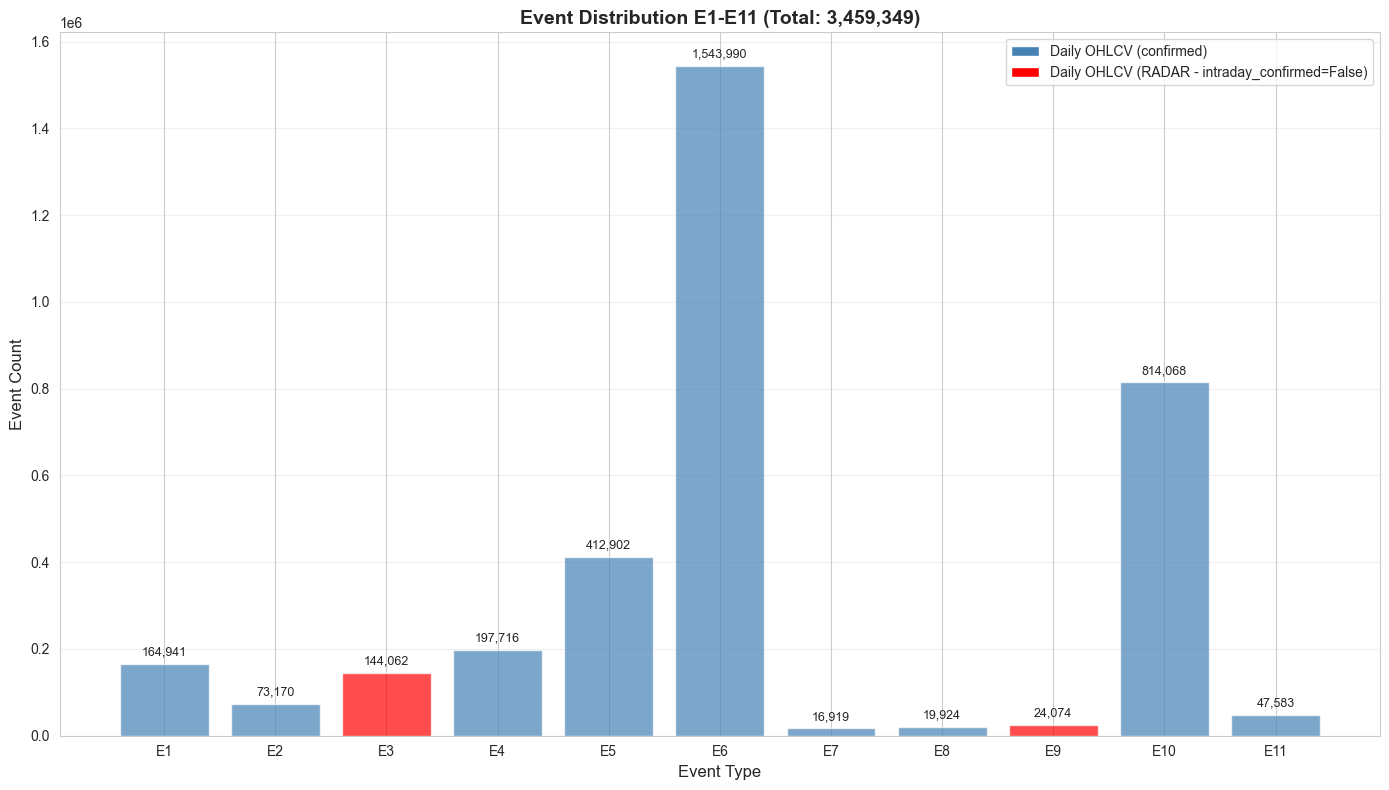

✅ Plot saved to event_distribution_E1_E11.png


In [7]:
# Bar chart: Event counts
fig, ax = plt.subplots(figsize=(14, 8))

event_counts = {k: len(v) for k, v in dfs.items()}
events = list(event_counts.keys())
counts = list(event_counts.values())

colors = ['red' if e in ['E3', 'E9'] else 'steelblue' for e in events]

ax.bar(events, counts, color=colors, alpha=0.7)
ax.set_xlabel('Event Type', fontsize=12)
ax.set_ylabel('Event Count', fontsize=12)
ax.set_title('Event Distribution E1-E11 (Total: 3,459,349)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, (event, count) in enumerate(zip(events, counts)):
    ax.text(i, count + 20000, f'{count:,}', ha='center', fontsize=9)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', label='Daily OHLCV (confirmed)'),
    Patch(facecolor='red', label='Daily OHLCV (RADAR - intraday_confirmed=False)')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig('event_distribution_E1_E11.png', dpi=300, bbox_inches='tight')
plt.show()

print('✅ Plot saved to event_distribution_E1_E11.png')

## 5. Temporal Distribution: Events Over Time

In [11]:
# Concatenate all events with event_type preserved
# FIX: E4 uses date_end, normalize to 'date' for temporal analysis
# IMPORTANT: Polars concat requires columns in same order
all_events = []
for event_type, df in dfs.items():
    # Handle different date column schemas
    if event_type == 'E4':
        # E4 has date_start and date_end, use date_end as the event date
        df_temp = df.select([
            'ticker',
            pl.col('date_end').alias('date'),
            'event_type'
        ])
    else:
        # All others have 'date' column (including E7)
        df_temp = df.select([
            'ticker',
            'date',
            'event_type'
        ])
    
    all_events.append(df_temp)

df_all = pl.concat(all_events, how='vertical')
print(f'Total events concatenated: {len(df_all):,}')
print()

# Group by year and event type
df_temporal = (
    df_all
    .with_columns([
        pl.col('date').dt.year().alias('year')
    ])
    .group_by(['year', 'event_type'])
    .agg(pl.count().alias('count'))
    .sort(['year', 'event_type'])
)

print('Events by year and type (sample):')
print(df_temporal.head(20))

Total events concatenated: 3,459,349

Events by year and type (sample):
shape: (20, 3)
┌──────┬───────────────────────┬───────┐
│ year ┆ event_type            ┆ count │
│ ---  ┆ ---                   ┆ ---   │
│ i32  ┆ str                   ┆ u32   │
╞══════╪═══════════════════════╪═══════╡
│ 2004 ┆ E10_FirstGreenBounce  ┆ 30296 │
│ 2004 ┆ E11_VolumeBounce      ┆ 1492  │
│ 2004 ┆ E1_VolExplosion       ┆ 5051  │
│ 2004 ┆ E2_GapUp              ┆ 1226  │
│ 2004 ┆ E3_PriceSpikeIntraday ┆ 1360  │
│ …    ┆ …                     ┆ …     │
│ 2005 ┆ E3_PriceSpikeIntraday ┆ 1145  │
│ 2005 ┆ E4_Parabolic          ┆ 1537  │
│ 2005 ┆ E5_BreakoutATH        ┆ 21044 │
│ 2005 ┆ E6_MultipleGreenDays  ┆ 64132 │
│ 2005 ┆ E7_FirstRedDay        ┆ 117   │
└──────┴───────────────────────┴───────┘


C:\Users\AlexJ\AppData\Local\Temp\ipykernel_33064\1650630852.py:35: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias('count'))


C:\Users\AlexJ\AppData\Local\Temp\ipykernel_33064\1019080696.py:5: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  df_pivot = df_temporal.pivot(index='year', columns='event_type', values='count').fill_null(0)


Available event types in pivot:
['E10_FirstGreenBounce', 'E11_VolumeBounce', 'E1_VolExplosion', 'E2_GapUp', 'E3_PriceSpikeIntraday', 'E4_Parabolic', 'E5_BreakoutATH', 'E6_MultipleGreenDays', 'E7_FirstRedDay', 'E8_GapDownViolent', 'E9_CrashIntraday']



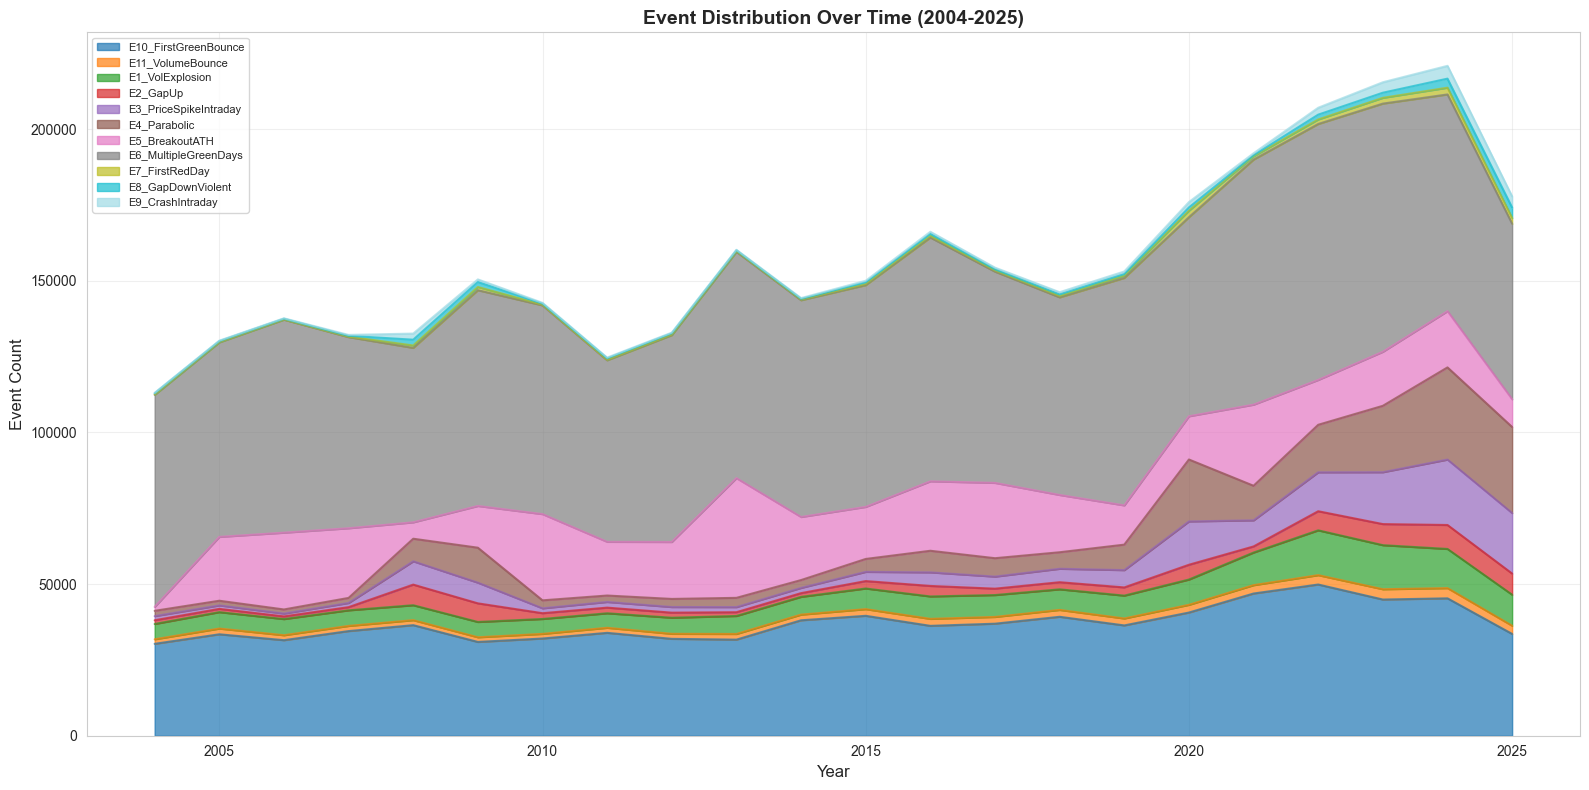

[OK] Plot saved to event_temporal_distribution.png


In [13]:
# Plot: Events over time (stacked area chart)
fig, ax = plt.subplots(figsize=(16, 8))

# Pivot for plotting
df_pivot = df_temporal.pivot(index='year', columns='event_type', values='count').fill_null(0)
df_pivot_pd = df_pivot.to_pandas().set_index('year')

# FIX: Use only columns that exist in the pivot
# Print available columns for debugging
print('Available event types in pivot:')
print(df_pivot_pd.columns.tolist())
print()

# Use only the columns that exist (dynamic ordering)
available_cols = df_pivot_pd.columns.tolist()

# Plot with available columns
df_pivot_pd[available_cols].plot(kind='area', stacked=True, ax=ax, alpha=0.7, colormap='tab20')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Event Count', fontsize=12)
ax.set_title('Event Distribution Over Time (2004-2025)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=8)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('event_temporal_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print('[OK] Plot saved to event_temporal_distribution.png')

## 6. Top 20 Tickers by Total Event Count

In [14]:
# Count events per ticker across all event types
df_ticker_counts = (
    df_all
    .group_by('ticker')
    .agg(pl.count().alias('total_events'))
    .sort('total_events', descending=True)
    .head(20)
)

print('Top 20 tickers by total event count:')
print(df_ticker_counts)
print()

# Save
df_ticker_counts.write_csv('top20_tickers_events.csv')
print('✅ Top 20 tickers saved to top20_tickers_events.csv')

Top 20 tickers by total event count:
shape: (20, 2)
┌────────┬──────────────┐
│ ticker ┆ total_events │
│ ---    ┆ ---          │
│ str    ┆ u32          │
╞════════╪══════════════╡
│ DCTH   ┆ 4797         │
│ ASTI   ┆ 3642         │
│ SBNY   ┆ 2334         │
│ SRNE   ┆ 1962         │
│ RNVA   ┆ 1877         │
│ …      ┆ …            │
│ JOUT   ┆ 1393         │
│ TPX    ┆ 1391         │
│ LPTH   ┆ 1391         │
│ AGM    ┆ 1389         │
│ TUP    ┆ 1385         │
└────────┴──────────────┘

✅ Top 20 tickers saved to top20_tickers_events.csv


C:\Users\AlexJ\AppData\Local\Temp\ipykernel_33064\32557455.py:5: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias('total_events'))


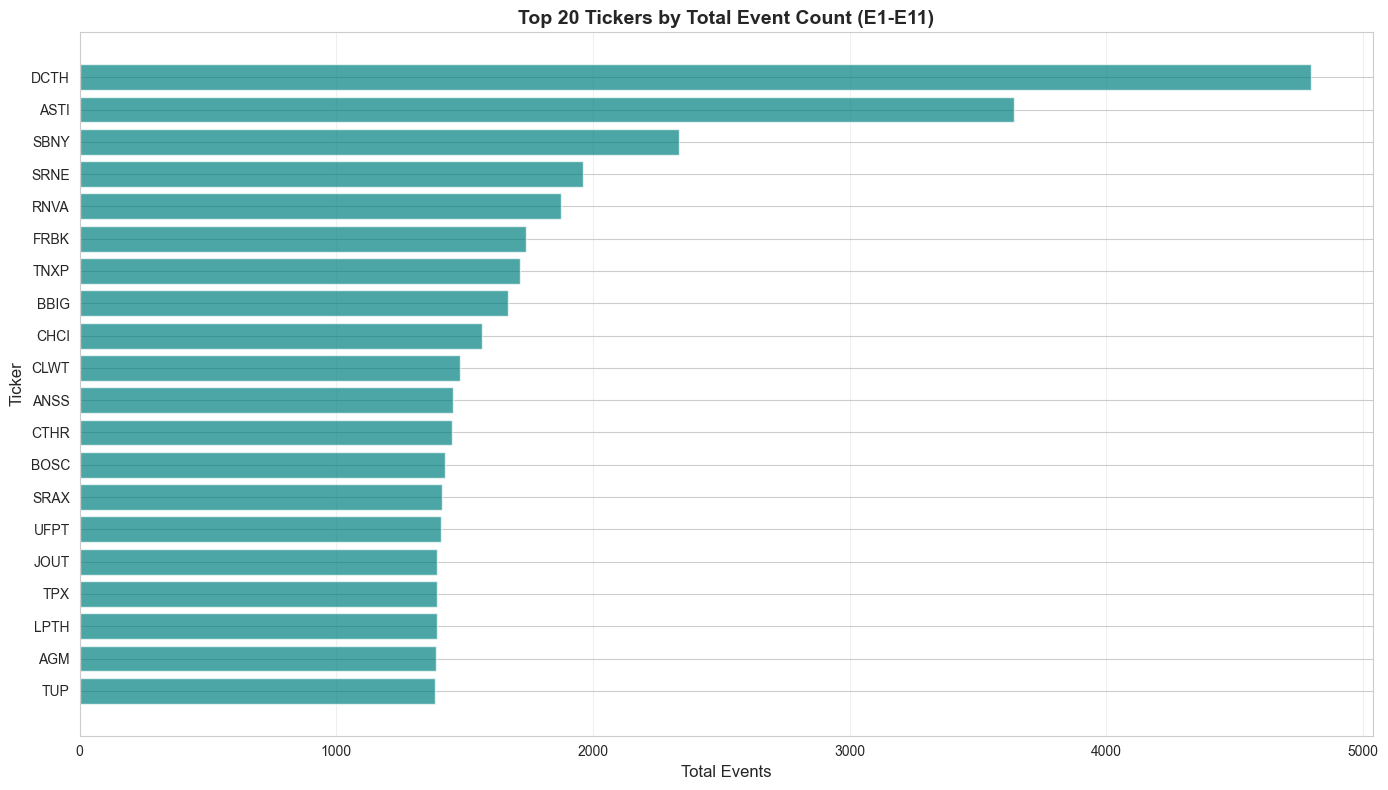

✅ Plot saved to top20_tickers_events.png


In [15]:
# Bar chart: Top 20 tickers
fig, ax = plt.subplots(figsize=(14, 8))

df_top20_pd = df_ticker_counts.to_pandas()
ax.barh(df_top20_pd['ticker'], df_top20_pd['total_events'], color='teal', alpha=0.7)
ax.set_xlabel('Total Events', fontsize=12)
ax.set_ylabel('Ticker', fontsize=12)
ax.set_title('Top 20 Tickers by Total Event Count (E1-E11)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('top20_tickers_events.png', dpi=300, bbox_inches='tight')
plt.show()

print('✅ Plot saved to top20_tickers_events.png')

## 7. Multi-Event Days Analysis

In [16]:
# Count unique events per ticker-date
df_multi_event = (
    df_all
    .group_by(['ticker', 'date'])
    .agg([
        pl.count().alias('event_count'),
        pl.col('event_type').unique().alias('event_types')
    ])
    .sort('event_count', descending=True)
)

print('Multi-event days statistics:')
print()

# Distribution of event count per day
event_count_dist = (
    df_multi_event
    .group_by('event_count')
    .agg(pl.count().alias('days'))
    .sort('event_count')
)

print(event_count_dist)
print()

# Top 10 days with most events
print('Top 10 days with most events:')
print(df_multi_event.head(10))

C:\Users\AlexJ\AppData\Local\Temp\ipykernel_33064\1481108497.py:6: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias('event_count'),


Multi-event days statistics:

shape: (11, 2)
┌─────────────┬─────────┐
│ event_count ┆ days    │
│ ---         ┆ ---     │
│ u32         ┆ u32     │
╞═════════════╪═════════╡
│ 1           ┆ 2601481 │
│ 2           ┆ 257837  │
│ 3           ┆ 39260   │
│ 4           ┆ 16116   │
│ 5           ┆ 8371    │
│ …           ┆ …       │
│ 7           ┆ 5408    │
│ 8           ┆ 3753    │
│ 9           ┆ 1236    │
│ 10          ┆ 211     │
│ 11          ┆ 15      │
└─────────────┴─────────┘

Top 10 days with most events:
shape: (10, 4)
┌────────┬────────────┬─────────────┬─────────────────────────────────┐
│ ticker ┆ date       ┆ event_count ┆ event_types                     │
│ ---    ┆ ---        ┆ ---         ┆ ---                             │
│ str    ┆ date       ┆ u32         ┆ list[str]                       │
╞════════╪════════════╪═════════════╪═════════════════════════════════╡
│ RGLS   ┆ 2024-03-12 ┆ 11          ┆ ["E3_PriceSpikeIntraday", "E4_… │
│ ALVR   ┆ 2020-07-30 ┆ 11         

C:\Users\AlexJ\AppData\Local\Temp\ipykernel_33064\1481108497.py:19: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias('days'))


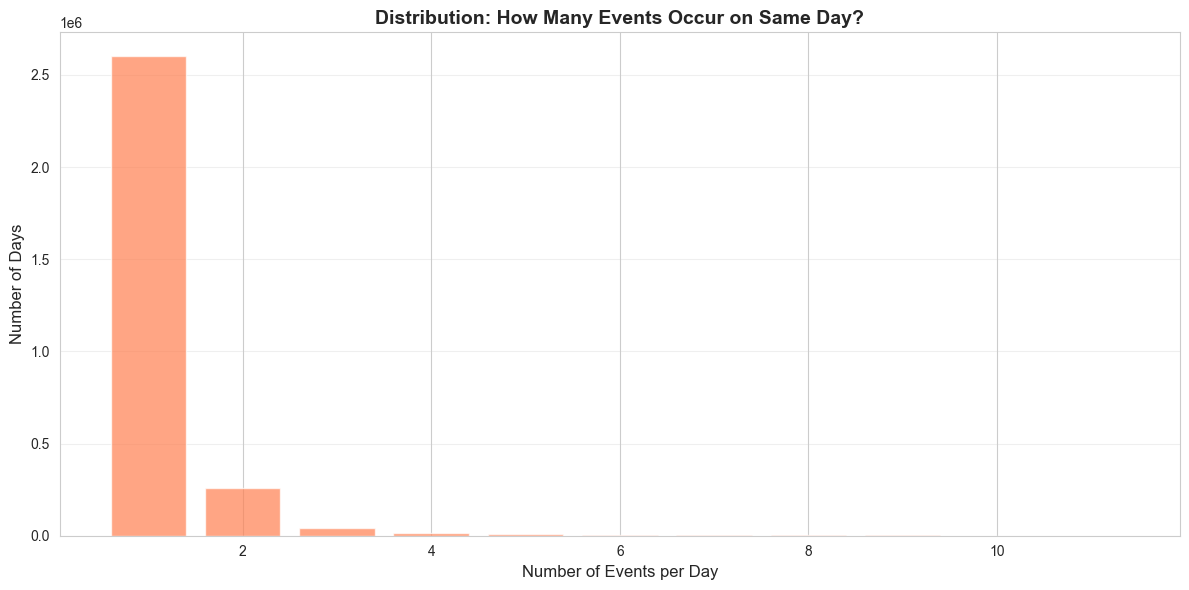

✅ Plot saved to multi_event_days_distribution.png


In [17]:
# Plot: Distribution of events per day
fig, ax = plt.subplots(figsize=(12, 6))

df_dist_pd = event_count_dist.to_pandas()
ax.bar(df_dist_pd['event_count'], df_dist_pd['days'], color='coral', alpha=0.7)
ax.set_xlabel('Number of Events per Day', fontsize=12)
ax.set_ylabel('Number of Days', fontsize=12)
ax.set_title('Distribution: How Many Events Occur on Same Day?', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('multi_event_days_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print('✅ Plot saved to multi_event_days_distribution.png')

## 8. Sample Data: E3 and E9 with `intraday_confirmed=False`

In [18]:
# Sample E3 events
print('=== E3 (Price Spike Intraday) Sample ===')
print()
print(dfs['E3'].head(10))
print()

# Verify flag
if 'intraday_confirmed' in dfs['E3'].columns:
    flag_values = dfs['E3']['intraday_confirmed'].unique()
    print(f'E3 intraday_confirmed unique values: {flag_values}')
    print(f'All E3 events have intraday_confirmed=False: {flag_values == [False]}')
else:
    print('❌ E3 intraday_confirmed column MISSING')

print()
print('=== E9 (Crash Intraday) Sample ===')
print()
print(dfs['E9'].head(10))
print()

# Verify flag
if 'intraday_confirmed' in dfs['E9'].columns:
    flag_values = dfs['E9']['intraday_confirmed'].unique()
    print(f'E9 intraday_confirmed unique values: {flag_values}')
    print(f'All E9 events have intraday_confirmed=False: {flag_values == [False]}')
else:
    print('❌ E9 intraday_confirmed column MISSING')

=== E3 (Price Spike Intraday) Sample ===

shape: (10, 10)
┌────────┬────────────┬───────────────┬───────────┬───┬───────────┬─────────┬─────────┬────────────┐
│ ticker ┆ date       ┆ event_type    ┆ spike_pct ┆ … ┆ h         ┆ l       ┆ c       ┆ v          │
│ ---    ┆ ---        ┆ ---           ┆ ---       ┆   ┆ ---       ┆ ---     ┆ ---     ┆ ---        │
│ str    ┆ date       ┆ str           ┆ f64       ┆   ┆ f64       ┆ f64     ┆ f64     ┆ f64        │
╞════════╪════════════╪═══════════════╪═══════════╪═══╪═══════════╪═════════╪═════════╪════════════╡
│ TPB    ┆ 2016-06-20 ┆ E3_PriceSpike ┆ 0.256614  ┆ … ┆ 9.5       ┆ 7.56    ┆ 9.35    ┆ 219851.0   │
│        ┆            ┆ Intraday      ┆           ┆   ┆           ┆         ┆         ┆            │
│ ANY    ┆ 2008-09-18 ┆ E3_PriceSpike ┆ 0.238386  ┆ … ┆ 13454.0   ┆ 8134.0  ┆ 13454.0 ┆ 4.6429     │
│        ┆            ┆ Intraday      ┆           ┆   ┆           ┆         ┆         ┆            │
│ PCSA   ┆ 2004-06-25 ┆ E3_PriceS

## 9. Event Co-occurrence Matrix

In [20]:
# Create binary matrix: ticker-date vs event_type
# FIX: Some events can occur multiple times per ticker-date (e.g., E6)
# Use max() aggregation to get binary presence (1 if event exists, 0 otherwise)
df_pivot_events = (
    df_all
    .with_columns([
        pl.lit(1).alias('present')
    ])
    .pivot(
        on='event_type',  # Changed from 'columns' to 'on' (new API)
        index=['ticker', 'date'], 
        values='present',
        aggregate_function='max'  # Use max to handle duplicates
    )
    .fill_null(0)
)

print('Binary event matrix (sample):')
print(df_pivot_events.head(10))

Binary event matrix (sample):
shape: (10, 13)
┌────────┬────────────┬────────────┬──────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ ticker ┆ date       ┆ E1_VolExpl ┆ E2_GapUp ┆ … ┆ E8_GapDown ┆ E9_CrashI ┆ E10_First ┆ E11_Volum │
│ ---    ┆ ---        ┆ osion      ┆ ---      ┆   ┆ Violent    ┆ ntraday   ┆ GreenBoun ┆ eBounce   │
│ str    ┆ date       ┆ ---        ┆ i32      ┆   ┆ ---        ┆ ---       ┆ ce        ┆ ---       │
│        ┆            ┆ i32        ┆          ┆   ┆ i32        ┆ i32       ┆ ---       ┆ i32       │
│        ┆            ┆            ┆          ┆   ┆            ┆           ┆ i32       ┆           │
╞════════╪════════════╪════════════╪══════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ AABA   ┆ 2019-09-24 ┆ 1          ┆ 0        ┆ … ┆ 1          ┆ 0         ┆ 0         ┆ 0         │
│ AAC    ┆ 2004-03-19 ┆ 1          ┆ 0        ┆ … ┆ 0          ┆ 0         ┆ 1         ┆ 1         │
│ AAC    ┆ 2004-05-07 ┆ 1          ┆ 0       

In [21]:
# Calculate co-occurrence matrix
event_cols = [col for col in df_pivot_events.columns if col not in ['ticker', 'date']]

# Convert to pandas for correlation matrix
df_events_pd = df_pivot_events.select(event_cols).to_pandas()
corr_matrix = df_events_pd.corr()

print('Event co-occurrence correlation matrix:')
print(corr_matrix)

Event co-occurrence correlation matrix:
                       E1_VolExplosion  E2_GapUp  E3_PriceSpikeIntraday  \
E1_VolExplosion               1.000000  0.032447               0.211784   
E2_GapUp                      0.032447  1.000000               0.024400   
E3_PriceSpikeIntraday         0.211784  0.024400               1.000000   
E4_Parabolic                  0.079549  0.063776               0.253194   
E5_BreakoutATH               -0.045797 -0.048299              -0.051289   
E6_MultipleGreenDays         -0.192410 -0.161099              -0.148078   
E7_FirstRedDay                0.000601  0.003317               0.003956   
E8_GapDownViolent             0.014235 -0.013197               0.174667   
E9_CrashIntraday              0.095987  0.101051               0.028050   
E10_FirstGreenBounce         -0.121561 -0.087303              -0.079559   
E11_VolumeBounce              0.166197  0.002261               0.106017   

                       E4_Parabolic  E5_BreakoutATH  E6_Mul

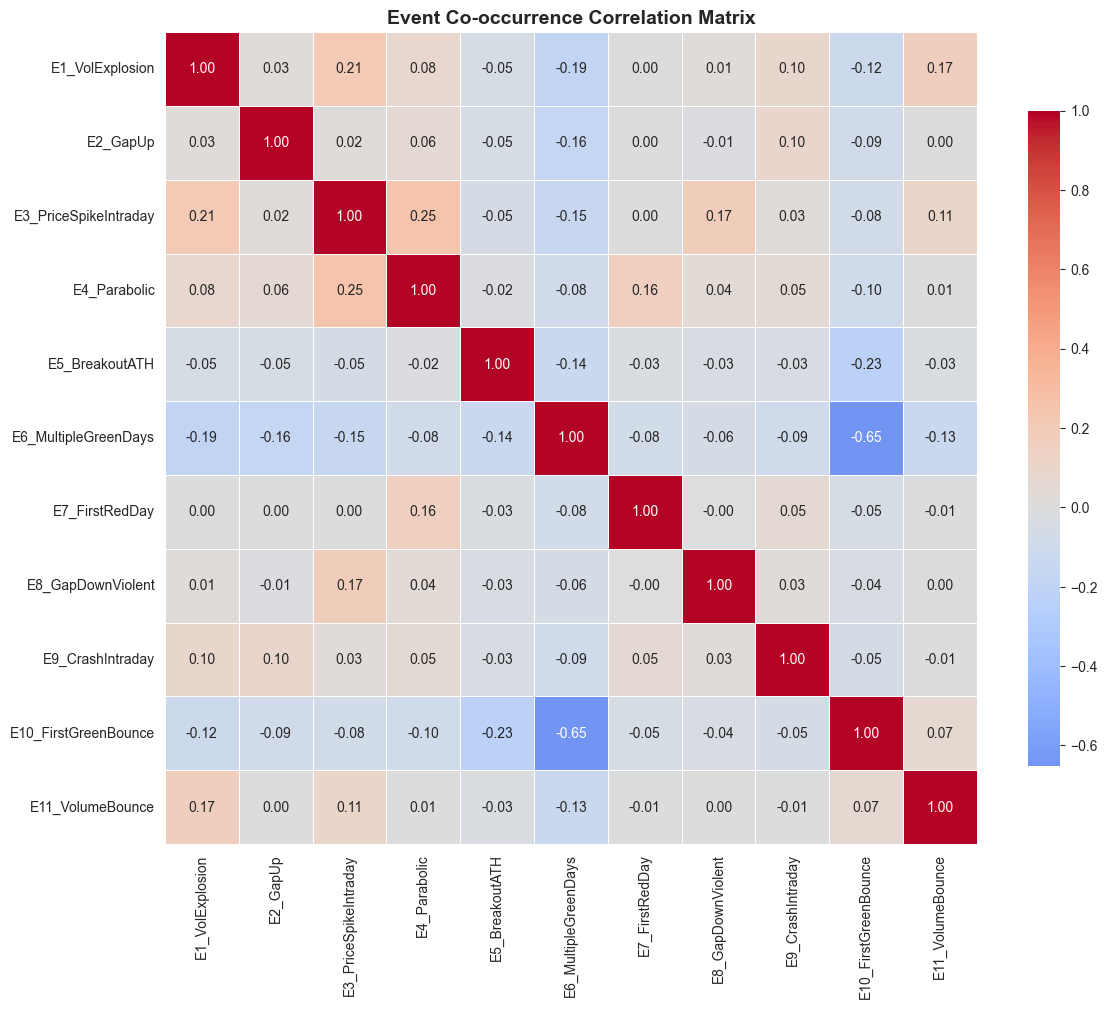

✅ Heatmap saved to event_cooccurrence_matrix.png


In [22]:
# Heatmap: Event co-occurrence
fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax)

ax.set_title('Event Co-occurrence Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('event_cooccurrence_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print('✅ Heatmap saved to event_cooccurrence_matrix.png')

## 10. Summary Report

In [24]:
print('=' * 80)
print('VALIDATION SUMMARY: EVENT DETECTION E1-E11')
print('=' * 80)
print()

print(f'Total events detected: {sum(len(df) for df in dfs.values()):,}')
print(f'Expected total: {sum(expected_counts.values()):,}')
print()

print('Event breakdown:')
for event_type, df in dfs.items():
    expected = expected_counts[event_type]
    actual = len(df)
    match = '[OK]' if actual == expected else '[MISMATCH]'
    print(f'  {match} {event_type}: {actual:,} (expected: {expected:,})')

print()
print('Schema validation:')
for event_type in ['E3', 'E9']:
    if event_type in dfs and 'intraday_confirmed' in dfs[event_type].columns:
        flag_value = dfs[event_type]['intraday_confirmed'][0]
        print(f'  [OK] {event_type}: intraday_confirmed={flag_value}')
    else:
        print(f'  [MISSING] {event_type}: intraday_confirmed column')

print()
print('Date range:')
# FIX: Handle E4 which has date_end instead of date
date_values = []
for event_type, df in dfs.items():
    if 'date' in df.columns:
        date_values.append(df['date'].min())
        date_values.append(df['date'].max())
    elif 'date_end' in df.columns:
        date_values.append(df['date_end'].min())
        date_values.append(df['date_end'].max())

if date_values:
    min_date = min(date_values)
    max_date = max(date_values)
    print(f'  {min_date} to {max_date}')
else:
    print('  No date information found')

print()
print('Unique tickers with events:')
all_tickers = set()
for df in dfs.values():
    if 'ticker' in df.columns:
        all_tickers.update(df['ticker'].unique().to_list())
print(f'  {len(all_tickers):,} tickers')

print()
print('Multi-event days:')
if 'df_multi_event' in locals() and len(df_multi_event) > 0:
    multi_event_days = df_multi_event.filter(pl.col('event_count') > 1)
    print(f'  {len(multi_event_days):,} days have 2+ events')
    max_events = df_multi_event['event_count'].max()
    print(f'  Max events on single day: {max_events}')
else:
    print('  Multi-event analysis not available')

print()
print('=' * 80)
print('[OK] VALIDATION COMPLETED')
print('=' * 80)

VALIDATION SUMMARY: EVENT DETECTION E1-E11

Total events detected: 3,459,349
Expected total: 3,459,349

Event breakdown:
  [OK] E1: 164,941 (expected: 164,941)
  [OK] E2: 73,170 (expected: 73,170)
  [OK] E3: 144,062 (expected: 144,062)
  [OK] E4: 197,716 (expected: 197,716)
  [OK] E5: 412,902 (expected: 412,902)
  [OK] E6: 1,543,990 (expected: 1,543,990)
  [OK] E7: 16,919 (expected: 16,919)
  [OK] E8: 19,924 (expected: 19,924)
  [OK] E9: 24,074 (expected: 24,074)
  [OK] E10: 814,068 (expected: 814,068)
  [OK] E11: 47,583 (expected: 47,583)

Schema validation:
  [OK] E3: intraday_confirmed=False
  [OK] E9: intraday_confirmed=False

Date range:
  2004-01-02 to 2025-10-24

Unique tickers with events:
  8,546 tickers

Multi-event days:
  338,343 days have 2+ events
  Max events on single day: 11

[OK] VALIDATION COMPLETED
